画像キャプショニング
-------------------
- NIC(NeuralImageCaptioning)の代表的なモデルとして「Show and Tell」がある
- Google社が2015年に発表したモデル
- 画像分類のために訓練されたCNNを用いて入力画像を順伝播させ、出力層の直前の特徴を抽出してRNNへの入力とし、そのRNNがキャプションを生成する
- 画像をCNNを用いて固定長の特徴空間にエンコードして、その特徴を出力側のRNNでデコードして画像の生成をするイメージ
- Show and Tellではエンコーダ側のCNNは画像分類用に訓練したモデルを採用している
    - あるドメインのタスクを元に訓練されたモデルを異なるタスクに利用することを「転移学習(Transfer Learning)」と呼ぶ
        - キャプションを生成するために学習されたわけではなくてもよく訓練されたモデルであれば画像の特徴をうまく捉えているため活用できる
- 自前でCNNを作成してRNNにつなげてすべてを1から学習してもうまくいかない
    - 自前で作るにはデータ量が少なすぎる
    - 画像と文書という異なるものを一気通貫でがく酒するのに誤差計算を行うのが文章に関する情報のみであり、過学習してしまうため
    - エンコーダ側は事前学習したモデルを用いる

画像キャプショニングのためのデータセット
-------------------------------
- 最もメジャーなものは、マイクロソフト社が提供しているMS-COCO(MichroSoft Common Objects in Context)
    - http://cocodataset.org/ からDLできる
    - キャプショニングだけではなく、物体認識や矩形検知、セグメンテーションなどもある

### STAIR Caption
- https://stair-lab-cit.github.io/STAIR-captions-web/
- COCOのキャプションを日本語に翻訳したデータ・セット

大規模データセットを扱うときの注意
-------------------------
- 大規模のデータセットを扱うときは、すべてのデータをメモリに乗せることは難しい
- とはいえ毎回訓練のたびにデータをディスクから読み取るのはIOのアクセス速度がボトルネックになる
- 一般的にはデータセット作成用のスレッドと訓練用のスレッドを分けてキューイングするのが定石

TFRecord形式によるデータのバイナリ化
-------------------------
- Tensorflowには、データをバイナリで扱うためのファイルフォーマットが用意されている

### データの書き出しサンプル

In [6]:
import glob
import tensorflow as tf

img_list = [i for i in glob.glob('img/*.jpg')]

# tfrecordのファイルをオープンする
with tf.python_io.TFRecordWriter('test.tfrecord')as w:
    # 画像ファイルをバイナリとして読み込む
    for img in img_list:
        # rbはreadとbinaryのフラグ
        with tf.gfile.FastGFile(img, 'rb') as f:
            data = f.read()
            # train.Featuresはキーバリュー形式で登録を行うクラス
            # 「data」というキーで画像のバイト配列を渡す
            # ※注意事項としてteaturesに登録するリストの個数は固定にしなくてはならない
            features = tf.train.Features(feature={'data': tf.train.Feature(bytes_list=tf.train.BytesList(value=[data]))
                                                 })
            # tfrecordへの書き出し
            example = tf.train.Example(features=features)
            w.write(example.SerializeToString())

### データの読み込みサンプル
- TFRecordファイルの読み込み方法はいくつかあるがここでは`DataSetAPI`を用いる

/Users/amoro/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


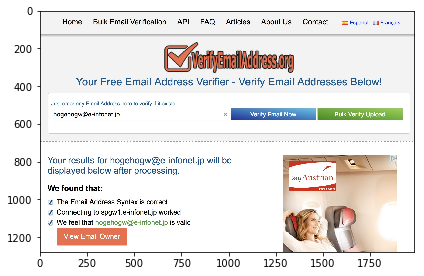

In [13]:
import tensorflow as tf
from skimage import io

def parse(example):
    
    # TFRecordをパース
    features = tf.parse_single_example(
        example,
        features={
                'data': tf.FixedLenFeature([], dtype=tf.string)
        }
    )
    # バイト列のままになっているので元の画像の形式に変換
    img = features['data']
    img = tf.image.decode_jpeg(img)
    return img

# TFReccordファイルを読み込みパース用の関数を適用
dataset = tf.data.TFRecordDataset(['test.tfrecord']).map(parse)

# データセットを1周するイテレータを生成
iterator = dataset.make_one_shot_iterator()
# イテレータから要素を取得
next_element = iterator.get_next()

with tf.Session() as sess:
    # データセットから画像を1件取得
    jpeg_img = sess.run(next_element)
    # scikit-imageで表示
    io.imshow(jpeg_img)
    io.show()

データセット整形プログラムの作成
---------------------
STAIR Captionsの正解データとCOCOの画像データを用いてTFRecordを作成する
流れは以下

```
- 1.STAIR Captionsのファイルを読み込んで画像IDからファイルパスとキャプション用の辞書を作成する
- 2.訓練用、検証用、テスト用にデータを分割する
- 3.訓練用のデータをもとに単語辞書を作成する
- 4.画像を読み込みTFRecord形式で画像とキャプションの組み合わせを1レコードとしてTFRecordに書き込む
```

また1つのTFRecordにすべてのデータを書き込んでしまうとデータが大きくなりすぎてしまうため、データを分割して複数のTFRecordファイルに書き込こむ

### STAIR Captionsの JSONファイルの仕様

#### 最上位

```json
{ 'info' : info, 'images' : [image], 'annotations' : [annotation], 'licenses' : [license], }
```

#### image

```
image { 'license' : int, 'file_ name' : str, 'coco_ url' : str, 'height' : int, 'width' : int, 'date_ captured' : datetime, 'flickr_ url': : str, 'id' : int, }
```

- 各画像のファイル名や画像サイズをもっている

#### annotation

```
annotation{ 'image_ id' : int, 'tokenized_ caption' : str 'id' : int, 'caption' : str, }
```

- キャプション情報を持っている
- COCOのデータとことなる部分としてtokenized_captionという項目をもっていおり、ここに形態素解析した結果をスペース区切りで格納している


### データ整形スクリプト
- サンプル: https://github.com/thinkitcojp/TensorFlowDL-samples/blob/master/nic/create_data_sets.py
- jupiterではmain関数を呼ぶとエラーが起きるので本来はphtyonファイルで実行するほうがよさそう

In [2]:
# 各種モジュールのインポートと定数定義
import os
import json
import numpy as np

from collections import namedtuple, Counter

import tensorflow as tf

In [3]:
# 定数定義
tf.flags.DEFINE_string("train_img_dir", "data/img/train2014/", "Training image directory.")
tf.flags.DEFINE_string("val_img_dir", "data/img/val2014/", "Validation image directory.")
tf.flags.DEFINE_string("train_captions", "data/stair_captions_v1.2_train.json", "Training caption file.")
tf.flags.DEFINE_string("val_captions", "data/stair_captions_v1.2_val.json", "Validation caption file.")
tf.flags.DEFINE_string("out_dir", "data/tfrecords/", "Output TFRecords directiory.")
tf.flags.DEFINE_integer("min_word_count", 4, "The minimum number of occurrences of each word in th training set for includion in the vocab.")
tf.flags.DEFINE_string("word_list_file", "data/dictionary.txt", "Output word list file.")

FLAGS = tf.flags.FLAGS

# 文章開始を表す
START_WORD = '<S>'
# 文章終了を表す
END_WORD = '<E>'
# 不明文字を表す
UNKNOWN_WORD = '<UNW>'

NUM_TRAIN_FILE = 256
NUM_VAL_FILE = 4
NUM_TEST_FILE = 8

In [5]:
ImageMetadata = namedtuple("ImageMetadata", ["img_id", "filename"])

In [ ]:
#